## Image cropping and pre-processing

Loading with OpenCV:
Image dimensions: 640x480 pixels


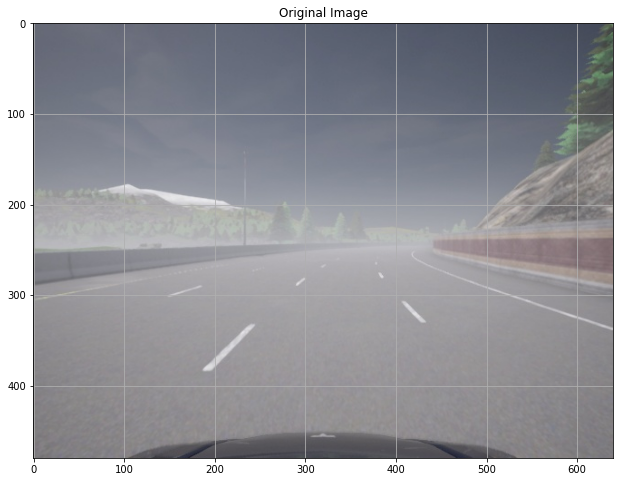


Loading with PIL:
Image dimensions: 640x480 pixels


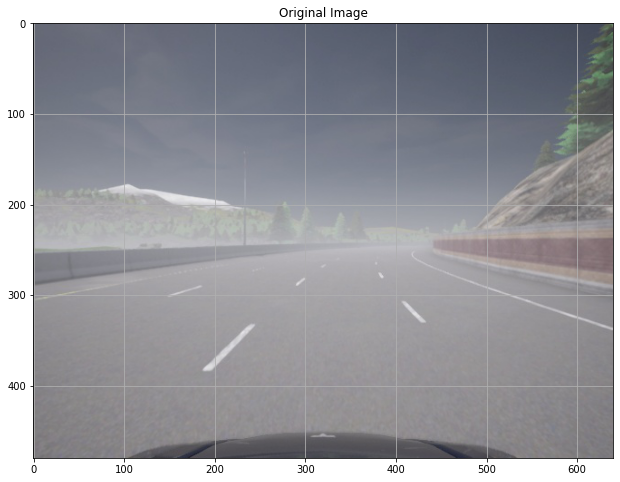

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_and_display_image_cv2(image_path):
    """
    Load and display image using OpenCV
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    
    # Convert from BGR to RGB (OpenCV loads in BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    height, width = img_rgb.shape[:2]
    print(f"Image dimensions: {width}x{height} pixels")
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('on')  # Show axis to help with identifying coordinates
    plt.grid(True)  # Add grid to help with identifying regions
    plt.title("Original Image")
    plt.show()
    
    return img_rgb, height, width

def load_and_display_image_pil(image_path):
    """
    Load and display image using PIL
    """
    # Open the image
    img = Image.open(image_path)
    
    # Get image dimensions
    width, height = img.size
    print(f"Image dimensions: {width}x{height} pixels")
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('on')  # Show axis to help with identifying coordinates
    plt.grid(True)  # Add grid to help with identifying regions
    plt.title("Original Image")
    plt.show()
    
    return img, height, width

# Path to your image
image_path = "carla_dataset/20241209_173218_948893_steering_0.0221.jpg"

# Try loading with both methods
print("Loading with OpenCV:")
try:
    img_cv2, height_cv2, width_cv2 = load_and_display_image_cv2(image_path)
except Exception as e:
    print(f"OpenCV loading failed: {e}")

print("\nLoading with PIL:")
try:
    img_pil, height_pil, width_pil = load_and_display_image_pil(image_path)
except Exception as e:
    print(f"PIL loading failed: {e}")

## Crop region

Original image dimensions: 640x480 pixels
Crop region dimensions: 640x240 pixels
After resizing to neural network input: 160x120 pixels


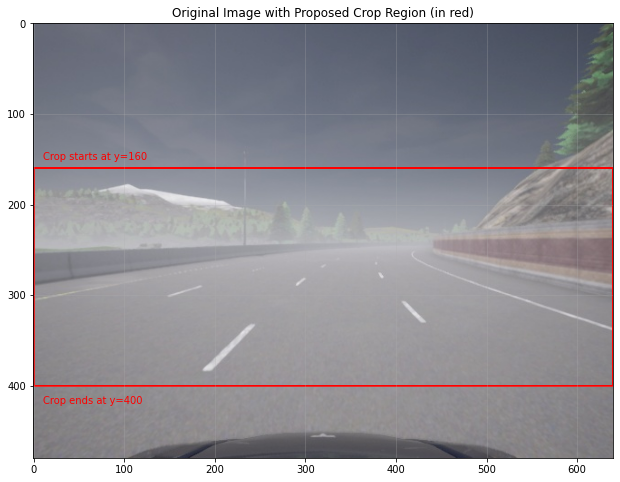

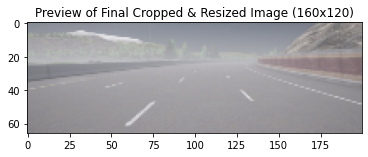

Original image dimensions: 640x480 pixels
Crop region dimensions: 640x180 pixels
After resizing to neural network input: 160x120 pixels


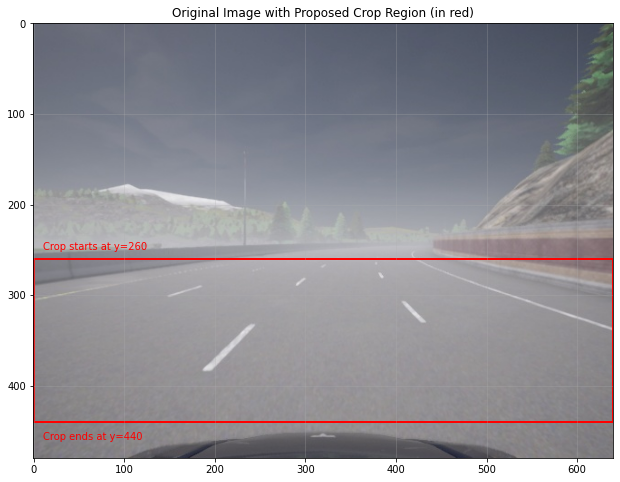

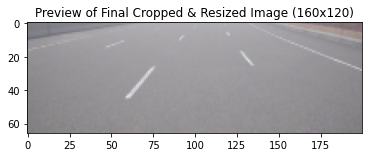

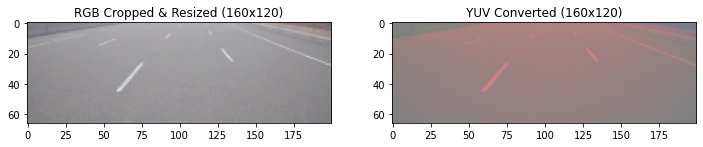

In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_crop_region(image_path, crop_top=160, crop_bottom=400):
    """
    Load image and visualize proposed crop region
    crop_top: y-coordinate where top crop begins
    crop_bottom: y-coordinate where bottom crop ends
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    
    # Convert from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    height, width = img_rgb.shape[:2]
    print(f"Original image dimensions: {width}x{height} pixels")
    
    # Calculate crop dimensions
    crop_height = crop_bottom - crop_top
    crop_width = width  # Using full width initially
    print(f"Crop region dimensions: {crop_width}x{crop_height} pixels")
    print(f"After resizing to neural network input: 160x120 pixels")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Display the image
    ax.imshow(img_rgb)
    
    # Create rectangle patch for crop region
    rect = Rectangle((0, crop_top), width, crop_height, 
                    linewidth=2, edgecolor='r', facecolor='none')
    
    # Add rectangle to plot
    ax.add_patch(rect)
    
    # Add grid and labels
    ax.grid(True, alpha=0.3)
    ax.set_title("Original Image with Proposed Crop Region (in red)")
    
    # Add text annotations
    plt.text(10, crop_top-10, f'Crop starts at y={crop_top}', color='red')
    plt.text(10, crop_bottom+20, f'Crop ends at y={crop_bottom}', color='red')
    
    plt.show()
    
    return img_rgb, height, width, crop_top, crop_bottom

# Path to your image
image_path = "carla_dataset/20241209_173218_948893_steering_0.0221.jpg"

# Visualize with initial crop suggestion
# Starting with a crop that removes approximately top third and bottom sixth of the image
img, height, width, crop_top, crop_bottom = visualize_crop_region(image_path)

def preview_final_crop(img, crop_top, crop_bottom):
    """
    Show what the final cropped and resized image would look like
    """
    # Crop the image
    cropped = img[crop_top:crop_bottom, :]
    
    # Resize to neural network input size
    resized = cv2.resize(cropped, (200,66))
    
    # Display
    plt.figure(figsize=(6, 4))
    plt.imshow(resized)
    plt.title("Preview of Final Cropped & Resized Image (160x120)")
    #plt.grid(True, alpha=0.3)
    plt.show()

def preview_final_crop_with_yuv(img, crop_top, crop_bottom):
    """
    Show both RGB and YUV versions of the final cropped and resized image
    """
    # Crop and resize
    cropped = img[crop_top:crop_bottom, :]
    resized = cv2.resize(cropped, (200,66))
    
    # Convert to YUV
    yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
    
    # Create side by side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # RGB image
    ax1.imshow(resized)
    ax1.set_title("RGB Cropped & Resized (160x120)")
    
    # YUV image
    ax2.imshow(yuv)
    ax2.set_title("YUV Converted (160x120)")
    
    plt.show()

# Show preview of final result
crop_top=160
crop_bottom=400
preview_final_crop(img, crop_top, crop_bottom)
crop_top=260
crop_bottom=440
img, height, width, crop_top, crop_bottom = visualize_crop_region(image_path, crop_top, crop_bottom)
preview_final_crop(img, crop_top, crop_bottom)
preview_final_crop_with_yuv(img, crop_top, crop_bottom)

## Downstream YUV function

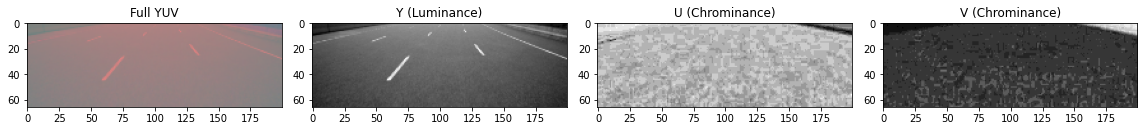

In [3]:
def prepare_image_for_neural_network(image_path, crop_top=260, crop_bottom=440):
    """
    Load image, crop, resize, and convert to YUV for neural network processing
    Args:
        image_path: Path to the input image
        crop_top: Y coordinate where crop begins (default 160)
        crop_bottom: Y coordinate where crop ends (default 400)
    Returns:
        numpy array in YUV format, size 120x160x3
    """
    # Read and convert image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Crop
    cropped = img_rgb[crop_top:crop_bottom, :]
    
    # Resize to neural network input size
    resized = cv2.resize(cropped, (200, 66))
    
    # Convert to YUV
    yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
    
    return yuv

def plot_yuv_channels(yuv_array):
    """
    Plot all channels of YUV image for visualization
    Args:
        yuv_array: YUV image array of shape (120, 160, 3)
    """
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Plot full YUV image
    axes[0].imshow(yuv_array)
    axes[0].set_title('Full YUV')
    
    # Plot individual channels
    channel_names = ['Y (Luminance)', 'U (Chrominance)', 'V (Chrominance)']
    for i in range(3):
        axes[i+1].imshow(yuv_array[:,:,i], cmap='gray')
        axes[i+1].set_title(channel_names[i])
    
    plt.tight_layout()
    plt.show()

# Test it on your processed image
crop_top=260
crop_bottom=440
yuv_array = prepare_image_for_neural_network("carla_dataset/20241209_173218_948893_steering_0.0221.jpg", crop_top, crop_bottom)
plot_yuv_channels(yuv_array)

## YUV array size

In [4]:
yuv_array.shape

(66, 200, 3)

: 